# Functional Encryption - Classification and information leakage
 
### Purpose

We try here to assess the resistance of a model to multiple collateral adversaries when resistance has been built agains a single big adversary, a CNN, in the distinguisher setting

The adversaries tested against are naturally the FNN and CNN seens earlier, but also more classical models of the sklearn library which have proved in Part 17 to be quite performant (Knn, Randomforest, etc.)

Todo:

- [ ] Better main task algorithm
- [ ] Comparison with other font pairs or letter
- [ ] Analysis interest fo Transfer Learning



## 1. Parameters and imports


We will use the code directly from the repo, to make the notebook more readable. Functions are similar to those presented earlier.

In [1]:
# Allow to load packages from parent
import sys, os
sys.path.insert(1, os.path.realpath(os.path.pardir))

In [2]:
import random

import numpy as np

import torch
import torch.nn as nn
import torch.optim as optim
import torch.nn.functional as F
import torch.utils.data as utils

import learn
from learn import show_results
from learn.distinguisher.data import get_data_loaders, get_collateral_data_loaders, get_collateral_datasets
from learn.distinguisher import resistance
from learn.distinguisher.models import ResistanceNet, N_FONTS

In [3]:
torch.set_num_threads(4)

In [4]:
class Parser:
    """Parameters for the training"""
    def __init__(self):
        self.epochs = 0
        self.sabotage_epochs = 20
        self.new_adversary_epochs = 10
        self.lr = 0.002
        self.momentum = 0.5
        self.test_batch_size = 1000
        self.batch_size = 64
        self.log_interval = 100

In [5]:
fonts = ['cursive', 'Georgia']
letter = 'p'

## 2. Building resistance

Let's define the model with the describes architecture. Basically you have 3 blocs: 1 quadratic and 2 CNN.

Next, we define the train and test functions. They assume the train_load return two labels: the char and the font of some input.

In the training phase we execute the 3 steps as described aboved.

In the test function, we just test the performance for the main and collateral tasks.

In [6]:
def build_resistance(model, alpha=0):
    """
    Perform a learning + a sabotage phase
    """
    args = Parser()
    
    train_loader, test_loader = get_data_loaders(args, *fonts)

    optimizer = optim.SGD(model.parameters(), lr=args.lr, momentum=args.momentum)
    
    test_perfs_char = []
    test_perfs_font = []
    
    for epoch in range(1, args.epochs + args.sabotage_epochs + 1):
        initial_phase = epoch <= args.epochs
        if initial_phase:
            print("(initial phase)")
        perturbate = epoch > args.epochs and epoch <= args.epochs + args.sabotage_epochs
        if perturbate:
            print("(perturbate)")
        new_adversary = False
        
        resistance.train(args, model, train_loader, optimizer, epoch, alpha, initial_phase, perturbate, new_adversary)
        test_perf_char, test_perf_font = resistance.test(args, model, test_loader, new_adversary)
        test_perfs_char.append(test_perf_char)
        test_perfs_font.append(test_perf_font)

    return test_perfs_char, test_perfs_font

In [7]:
path = '../data/models/part21_ResistanceNet.pt'
model = ResistanceNet()
results = {}

try:
    model.load_state_dict(torch.load(path))
    model.eval()
    print('Model loaded!')
except FileNotFoundError:
    print('Computing model...')
    
alpha=1.5
test_perfs_char_perturbate, test_perfs_font_perturbate = build_resistance(model, alpha=alpha)
results[f"Main task with perturbation alpha={alpha}"] = test_perfs_char_perturbate
results[f"Collateral task with perturbation alpha={alpha}"] = test_perfs_font_perturbate

model.results = results
# save model
torch.save(model.state_dict(), path)

Model loaded!
Training set 60000 items
Testing set  10000 items
(perturbate)
Train Epoch: 1 [0/60000 (0%)]	Loss Char: 0.023416 Loss Font: 0.709359
Train Epoch: 1 [6400/60000 (11%)]	Loss Char: 0.010806 Loss Font: 0.643880
Train Epoch: 1 [12800/60000 (21%)]	Loss Char: 0.022700 Loss Font: 0.676551
Train Epoch: 1 [19200/60000 (32%)]	Loss Char: 0.024775 Loss Font: 0.678881
Train Epoch: 1 [25600/60000 (43%)]	Loss Char: 0.018922 Loss Font: 0.673824
Train Epoch: 1 [32000/60000 (53%)]	Loss Char: 0.020082 Loss Font: 0.667138
Train Epoch: 1 [38400/60000 (64%)]	Loss Char: 0.011325 Loss Font: 0.668868
Train Epoch: 1 [44800/60000 (75%)]	Loss Char: 0.078868 Loss Font: 0.671503
Train Epoch: 1 [51200/60000 (85%)]	Loss Char: 0.048208 Loss Font: 0.672911
Train Epoch: 1 [57600/60000 (96%)]	Loss Char: 0.011414 Loss Font: 0.655295

Test set: Accuracy Char : 9376/10000 (93.76%)
          Accuracy Font : 5364/10000 (53.64%)
(perturbate)
Train Epoch: 2 [0/60000 (0%)]	Loss Char: 0.014197 Loss Font: 0.667739
Tra

Train Epoch: 10 [44800/60000 (75%)]	Loss Char: 0.003108 Loss Font: 0.685337
Train Epoch: 10 [51200/60000 (85%)]	Loss Char: 0.007045 Loss Font: 0.684274
Train Epoch: 10 [57600/60000 (96%)]	Loss Char: 0.001968 Loss Font: 0.688284

Test set: Accuracy Char : 9572/10000 (95.72%)
          Accuracy Font : 5284/10000 (52.84%)
(perturbate)
Train Epoch: 11 [0/60000 (0%)]	Loss Char: 0.002466 Loss Font: 0.693045
Train Epoch: 11 [6400/60000 (11%)]	Loss Char: 0.008409 Loss Font: 0.694260
Train Epoch: 11 [12800/60000 (21%)]	Loss Char: 0.005219 Loss Font: 0.680468
Train Epoch: 11 [19200/60000 (32%)]	Loss Char: 0.007290 Loss Font: 0.684880
Train Epoch: 11 [25600/60000 (43%)]	Loss Char: 0.006512 Loss Font: 0.688030
Train Epoch: 11 [32000/60000 (53%)]	Loss Char: 0.025660 Loss Font: 0.694489
Train Epoch: 11 [38400/60000 (64%)]	Loss Char: 0.007089 Loss Font: 0.674767
Train Epoch: 11 [44800/60000 (75%)]	Loss Char: 0.012443 Loss Font: 0.680877
Train Epoch: 11 [51200/60000 (85%)]	Loss Char: 0.004664 Loss Fon

Train Epoch: 20 [12800/60000 (21%)]	Loss Char: 0.056439 Loss Font: 0.662513
Train Epoch: 20 [19200/60000 (32%)]	Loss Char: 0.010429 Loss Font: 0.668954
Train Epoch: 20 [25600/60000 (43%)]	Loss Char: 0.026811 Loss Font: 0.671905
Train Epoch: 20 [32000/60000 (53%)]	Loss Char: 0.017570 Loss Font: 0.620595
Train Epoch: 20 [38400/60000 (64%)]	Loss Char: 0.011179 Loss Font: 0.670534
Train Epoch: 20 [44800/60000 (75%)]	Loss Char: 0.013034 Loss Font: 0.649312
Train Epoch: 20 [51200/60000 (85%)]	Loss Char: 0.019281 Loss Font: 0.664521
Train Epoch: 20 [57600/60000 (96%)]	Loss Char: 0.021836 Loss Font: 0.639055

Test set: Accuracy Char : 9349/10000 (93.49%)
          Accuracy Font : 5614/10000 (56.14%)


# 3. Testing resistance with multiple models

In [8]:
quadratic_model = model
quadratic_model.freeze('quad')

In [9]:
def evaluate_resistance(model, alpha=0):

    args = Parser()
    
    train_loader, test_loader = get_collateral_data_loaders(args, *fonts, letter)

    optimizer = optim.SGD(model.parameters(), lr=args.lr, momentum=args.momentum)
    
    test_perfs_char = []
    test_perfs_font = []
    
    for epoch in range(1, args.new_adversary_epochs + 1):
        initial_phase = False
        perturbate = False
        new_adversary = True
        
        resistance.train(args, model, train_loader, optimizer, epoch, alpha, initial_phase, perturbate, new_adversary)
        test_perf_char, test_perf_font = resistance.test(args, model, test_loader, new_adversary)
        test_perfs_char.append(test_perf_char)
        test_perfs_font.append(test_perf_font)

    return test_perfs_char, test_perfs_font

In [10]:
class BaseNet(nn.Module):
    def __init__(self, quadratic_model):
        super(BaseNet, self).__init__()
        self.proj1 = quadratic_model.proj1
        self.diag1 = quadratic_model.diag1
        
    def quad(self, x):
        """Same as forward up to the junction part
        Used for the collateral training"""
        # --- Quadratic 
        x = x.view(-1, 784)
        x = self.proj1(x)
        x = x * x
        x = self.diag1(x)
        return x
    
    def conv_font(self, x):
        pass
    
    def forward_adv_font(self, x):
        x = self.quad(x)
        x = self.conv_font(x)
        return F.log_softmax(x, dim=1)
    
    def get_params(self, net):
        """Select the params for a given part of the net"""
        if net == 'quad':
            layers = [self.proj1, self.diag1]
        else:
            raise AttributeError(f'{net} type not recognized')
        params = [p for layer in layers for p in layer.parameters()]
        return params
    
    def freeze(self, net):
        """Freeze a part of the net"""
        net_params = self.get_params(net)
        for param in net_params:
            param.requires_grad = False
            
    def unfreeze(self):
        """Unfreeze the net"""
        for param in self.parameters():
            param.requires_grad = True

In [11]:
resistance_reports = {}

## 3.1 Fully connected models 

In [12]:
class FFNet(BaseNet):
    def __init__(self, architecture, quadratic_model):
        super(FFNet, self).__init__(quadratic_model)
        # --- FFNs for font families
        self.architecture = architecture
        n_layer = len(architecture) + 1
        input_size = 8
        for i_layer, output_size in enumerate(architecture):
            setattr(self, f"net_{i_layer}", nn.Linear(input_size, output_size))
            input_size = output_size
        setattr(self, f"net_{n_layer}", nn.Linear(input_size, N_FONTS)) 
    
    def conv_font(self, x):
        # --- FFN
        architecture = self.architecture
        n_layer = len(architecture) + 1
        for i_layer, output_size in enumerate(architecture):
            linear = getattr(self, f"net_{i_layer}")
            x = F.relu(linear(x))
        linear = getattr(self, f"net_{n_layer}")  
        x = linear(x)
        return x
        
        

Training set 60000 items
Testing set  10000 items
Train Epoch: 1 [0/60000 (0%)]	Loss Char: 0.000000 Loss Font: 0.865262
Train Epoch: 1 [6400/60000 (11%)]	Loss Char: 0.000000 Loss Font: 0.711883
Train Epoch: 1 [12800/60000 (21%)]	Loss Char: 0.000000 Loss Font: 0.696630
Train Epoch: 1 [19200/60000 (32%)]	Loss Char: 0.000000 Loss Font: 0.677602
Train Epoch: 1 [25600/60000 (43%)]	Loss Char: 0.000000 Loss Font: 0.692440
Train Epoch: 1 [32000/60000 (53%)]	Loss Char: 0.000000 Loss Font: 0.709739
Train Epoch: 1 [38400/60000 (64%)]	Loss Char: 0.000000 Loss Font: 0.679887
Train Epoch: 1 [44800/60000 (75%)]	Loss Char: 0.000000 Loss Font: 0.674035
Train Epoch: 1 [51200/60000 (85%)]	Loss Char: 0.000000 Loss Font: 0.680798
Train Epoch: 1 [57600/60000 (96%)]	Loss Char: 0.000000 Loss Font: 0.676420

Test set: Accuracy Char : 0/10000 (0.00%)
          Accuracy Font : 5064/10000 (50.64%)
Train Epoch: 2 [0/60000 (0%)]	Loss Char: 0.000000 Loss Font: 0.747373
Train Epoch: 2 [6400/60000 (11%)]	Loss Char: 0.


Test set: Accuracy Char : 0/10000 (0.00%)
          Accuracy Font : 6700/10000 (67.00%)
Training set 60000 items
Testing set  10000 items
Train Epoch: 1 [0/60000 (0%)]	Loss Char: 0.000000 Loss Font: 3.153012
Train Epoch: 1 [6400/60000 (11%)]	Loss Char: 0.000000 Loss Font: 0.700897
Train Epoch: 1 [12800/60000 (21%)]	Loss Char: 0.000000 Loss Font: 0.685088
Train Epoch: 1 [19200/60000 (32%)]	Loss Char: 0.000000 Loss Font: 0.682178
Train Epoch: 1 [25600/60000 (43%)]	Loss Char: 0.000000 Loss Font: 0.699255
Train Epoch: 1 [32000/60000 (53%)]	Loss Char: 0.000000 Loss Font: 0.694111
Train Epoch: 1 [38400/60000 (64%)]	Loss Char: 0.000000 Loss Font: 0.683041
Train Epoch: 1 [44800/60000 (75%)]	Loss Char: 0.000000 Loss Font: 0.680632
Train Epoch: 1 [51200/60000 (85%)]	Loss Char: 0.000000 Loss Font: 0.692926
Train Epoch: 1 [57600/60000 (96%)]	Loss Char: 0.000000 Loss Font: 0.676642

Test set: Accuracy Char : 0/10000 (0.00%)
          Accuracy Font : 5353/10000 (53.53%)
Train Epoch: 2 [0/60000 (0%)

Train Epoch: 10 [57600/60000 (96%)]	Loss Char: 0.000000 Loss Font: 0.639863

Test set: Accuracy Char : 0/10000 (0.00%)
          Accuracy Font : 6312/10000 (63.12%)
Training set 60000 items
Testing set  10000 items
Train Epoch: 1 [0/60000 (0%)]	Loss Char: 0.000000 Loss Font: 4.393295
Train Epoch: 1 [6400/60000 (11%)]	Loss Char: 0.000000 Loss Font: 0.691810
Train Epoch: 1 [12800/60000 (21%)]	Loss Char: 0.000000 Loss Font: 0.681004
Train Epoch: 1 [19200/60000 (32%)]	Loss Char: 0.000000 Loss Font: 0.671423
Train Epoch: 1 [25600/60000 (43%)]	Loss Char: 0.000000 Loss Font: 0.695024
Train Epoch: 1 [32000/60000 (53%)]	Loss Char: 0.000000 Loss Font: 0.700179
Train Epoch: 1 [38400/60000 (64%)]	Loss Char: 0.000000 Loss Font: 0.664026
Train Epoch: 1 [44800/60000 (75%)]	Loss Char: 0.000000 Loss Font: 0.646440
Train Epoch: 1 [51200/60000 (85%)]	Loss Char: 0.000000 Loss Font: 0.712691
Train Epoch: 1 [57600/60000 (96%)]	Loss Char: 0.000000 Loss Font: 0.680974

Test set: Accuracy Char : 0/10000 (0.00%

Train Epoch: 10 [44800/60000 (75%)]	Loss Char: 0.000000 Loss Font: 0.612872
Train Epoch: 10 [51200/60000 (85%)]	Loss Char: 0.000000 Loss Font: 0.612499
Train Epoch: 10 [57600/60000 (96%)]	Loss Char: 0.000000 Loss Font: 0.632077

Test set: Accuracy Char : 0/10000 (0.00%)
          Accuracy Font : 6157/10000 (61.57%)
Training set 60000 items
Testing set  10000 items
Train Epoch: 1 [0/60000 (0%)]	Loss Char: 0.000000 Loss Font: 4.831322
Train Epoch: 1 [6400/60000 (11%)]	Loss Char: 0.000000 Loss Font: 0.758105
Train Epoch: 1 [12800/60000 (21%)]	Loss Char: 0.000000 Loss Font: 0.689071
Train Epoch: 1 [19200/60000 (32%)]	Loss Char: 0.000000 Loss Font: 0.622131
Train Epoch: 1 [25600/60000 (43%)]	Loss Char: 0.000000 Loss Font: 0.691119
Train Epoch: 1 [32000/60000 (53%)]	Loss Char: 0.000000 Loss Font: 0.682788
Train Epoch: 1 [38400/60000 (64%)]	Loss Char: 0.000000 Loss Font: 0.671731
Train Epoch: 1 [44800/60000 (75%)]	Loss Char: 0.000000 Loss Font: 0.641630
Train Epoch: 1 [51200/60000 (85%)]	Loss

Train Epoch: 10 [32000/60000 (53%)]	Loss Char: 0.000000 Loss Font: 0.688999
Train Epoch: 10 [38400/60000 (64%)]	Loss Char: 0.000000 Loss Font: 0.658783
Train Epoch: 10 [44800/60000 (75%)]	Loss Char: 0.000000 Loss Font: 0.589011
Train Epoch: 10 [51200/60000 (85%)]	Loss Char: 0.000000 Loss Font: 0.607943
Train Epoch: 10 [57600/60000 (96%)]	Loss Char: 0.000000 Loss Font: 0.613966

Test set: Accuracy Char : 0/10000 (0.00%)
          Accuracy Font : 6581/10000 (65.81%)
Training set 60000 items
Testing set  10000 items
Train Epoch: 1 [0/60000 (0%)]	Loss Char: 0.000000 Loss Font: 1.285181
Train Epoch: 1 [6400/60000 (11%)]	Loss Char: 0.000000 Loss Font: 0.724001
Train Epoch: 1 [12800/60000 (21%)]	Loss Char: 0.000000 Loss Font: 0.692637
Train Epoch: 1 [19200/60000 (32%)]	Loss Char: 0.000000 Loss Font: 0.639603
Train Epoch: 1 [25600/60000 (43%)]	Loss Char: 0.000000 Loss Font: 0.697373
Train Epoch: 1 [32000/60000 (53%)]	Loss Char: 0.000000 Loss Font: 0.696674
Train Epoch: 1 [38400/60000 (64%)]	Lo

Train Epoch: 10 [19200/60000 (32%)]	Loss Char: 0.000000 Loss Font: 0.646661
Train Epoch: 10 [25600/60000 (43%)]	Loss Char: 0.000000 Loss Font: 0.617623
Train Epoch: 10 [32000/60000 (53%)]	Loss Char: 0.000000 Loss Font: 0.725170
Train Epoch: 10 [38400/60000 (64%)]	Loss Char: 0.000000 Loss Font: 0.661983
Train Epoch: 10 [44800/60000 (75%)]	Loss Char: 0.000000 Loss Font: 0.570659
Train Epoch: 10 [51200/60000 (85%)]	Loss Char: 0.000000 Loss Font: 0.595478
Train Epoch: 10 [57600/60000 (96%)]	Loss Char: 0.000000 Loss Font: 0.644143

Test set: Accuracy Char : 0/10000 (0.00%)
          Accuracy Font : 6469/10000 (64.69%)
Training set 60000 items
Testing set  10000 items
Train Epoch: 1 [0/60000 (0%)]	Loss Char: 0.000000 Loss Font: 23.042330
Train Epoch: 1 [6400/60000 (11%)]	Loss Char: 0.000000 Loss Font: 0.714550
Train Epoch: 1 [12800/60000 (21%)]	Loss Char: 0.000000 Loss Font: 0.693036
Train Epoch: 1 [19200/60000 (32%)]	Loss Char: 0.000000 Loss Font: 0.645052
Train Epoch: 1 [25600/60000 (43%)]

Train Epoch: 10 [12800/60000 (21%)]	Loss Char: 0.000000 Loss Font: 0.653238
Train Epoch: 10 [19200/60000 (32%)]	Loss Char: 0.000000 Loss Font: 0.648378
Train Epoch: 10 [25600/60000 (43%)]	Loss Char: 0.000000 Loss Font: 0.638060
Train Epoch: 10 [32000/60000 (53%)]	Loss Char: 0.000000 Loss Font: 0.725748
Train Epoch: 10 [38400/60000 (64%)]	Loss Char: 0.000000 Loss Font: 0.696748
Train Epoch: 10 [44800/60000 (75%)]	Loss Char: 0.000000 Loss Font: 0.639535
Train Epoch: 10 [51200/60000 (85%)]	Loss Char: 0.000000 Loss Font: 0.584567
Train Epoch: 10 [57600/60000 (96%)]	Loss Char: 0.000000 Loss Font: 0.592571

Test set: Accuracy Char : 0/10000 (0.00%)
          Accuracy Font : 6160/10000 (61.60%)


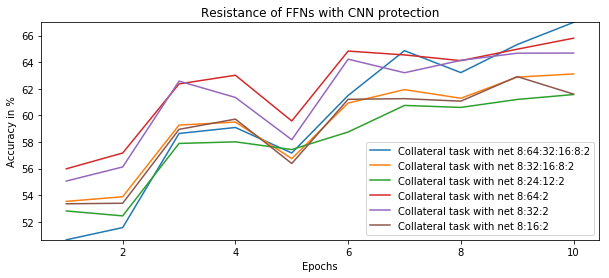

In [13]:
architectures = [[64, 32, 16, 8], [32, 16, 8], [24, 12], [64], [32], [16]]

for architecture in architectures:
    model = FFNet(architecture, quadratic_model)
    _, test_perfs_font = evaluate_resistance(model)
    
    architecture = ':'.join(map(str, [8] + architecture + [N_FONTS]))
    resistance_reports[f"Collateral task with net {architecture}"] = test_perfs_font
    
show_results(resistance_reports, title="Resistance of FFNs with CNN protection")


## 3.2 CNN models

In [14]:
class CNNet2(BaseNet):
    def __init__(self, nn_modules, quadratic_model):
        super(CNNet2, self).__init__(quadratic_model)

        self.jc = nn.Linear(8, 784)
            
        self.cv1 = nn.Conv2d(1, 20, 5, 1)
        self.cv2 = nn.Conv2d(20, 50, 5, 1)
        self.ln1 = nn.Linear(4*4*50, 500)
        self.ln2 = nn.Linear(500, N_FONTS)
    
    def conv_font(self, x):
        
        x = self.jc(x)
        x = x.view(-1, 1, 28, 28)
        
        # --- CNN
        x = F.relu(self.cv1(x))
        x = F.max_pool2d(x, 2, 2)
        x = F.relu(self.cv2(x))
        x = F.max_pool2d(x, 2, 2)
        x = x.view(-1, 4*4*50)
        x = F.relu(self.ln1(x))
        x = self.ln2(x)
        return x
         

In [15]:
class CNNet(BaseNet):
    def __init__(self, nn_modules, quadratic_model):
        super(CNNet, self).__init__(quadratic_model)
        # --- CNNs for font families
        self.nn_modules = nn_modules
        setattr(self, "net_0", nn.Linear(8, 784))
        for i_layer, nn_module in enumerate(nn_modules):
            setattr(self, f"net_{i_layer + 1}", nn_module)
    
    def conv_font(self, x):
        switched_from_conv_lin = False
        out_channels = []
        # Make the junction
        linear = getattr(self, "net_0")  
        x = linear(x)
        x = x.view(-1, 1, 28, 28)
        # --- CNN
        for i_layer, _ in enumerate(self.nn_modules):
            layer = getattr(self, f"net_{i_layer + 1}")
            if isinstance(layer, nn.Conv2d): # Conv layer
                x = F.relu(layer(x))
                x = F.max_pool2d(x, 2, 2)
                out_channels.append(layer.out_channels)
            else: # Linear layer
                if not switched_from_conv_lin:
                    x = x.view(-1, 4*4*out_channels[-1])
                    switched_from_conv_lin = True
                if i_layer < len(self.nn_modules) - 1:
                    x = F.relu(layer(x))
                else:
                    x = layer(x)
        return x
         

Training set 60000 items
Testing set  10000 items
Train Epoch: 1 [0/60000 (0%)]	Loss Char: 0.000000 Loss Font: 5.064341
Train Epoch: 1 [6400/60000 (11%)]	Loss Char: 0.000000 Loss Font: 0.699973
Train Epoch: 1 [12800/60000 (21%)]	Loss Char: 0.000000 Loss Font: 0.684715
Train Epoch: 1 [19200/60000 (32%)]	Loss Char: 0.000000 Loss Font: 0.680695
Train Epoch: 1 [25600/60000 (43%)]	Loss Char: 0.000000 Loss Font: 0.688536
Train Epoch: 1 [32000/60000 (53%)]	Loss Char: 0.000000 Loss Font: 0.707896
Train Epoch: 1 [38400/60000 (64%)]	Loss Char: 0.000000 Loss Font: 0.680318
Train Epoch: 1 [44800/60000 (75%)]	Loss Char: 0.000000 Loss Font: 0.663826
Train Epoch: 1 [51200/60000 (85%)]	Loss Char: 0.000000 Loss Font: 0.675490
Train Epoch: 1 [57600/60000 (96%)]	Loss Char: 0.000000 Loss Font: 0.675696

Test set: Accuracy Char : 0/10000 (0.00%)
          Accuracy Font : 5325/10000 (53.25%)
Train Epoch: 2 [0/60000 (0%)]	Loss Char: 0.000000 Loss Font: 0.721772
Train Epoch: 2 [6400/60000 (11%)]	Loss Char: 0.

Train Epoch: 10 [57600/60000 (96%)]	Loss Char: 0.000000 Loss Font: 0.577890

Test set: Accuracy Char : 0/10000 (0.00%)
          Accuracy Font : 6746/10000 (67.46%)


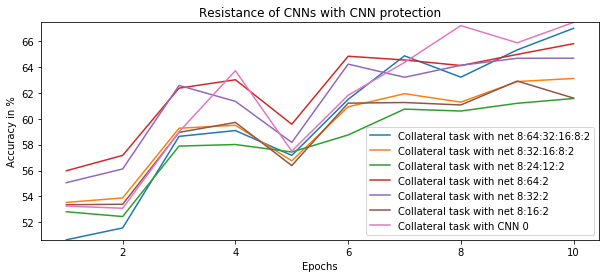

In [16]:
architectures = [
    (
        nn.Conv2d(1, 20, 5, 1),
        nn.Conv2d(20, 50, 5, 1),
        nn.Linear(4*4*50, 500),
        nn.Linear(500, N_FONTS)
    )
]
"""    ,
    (
        nn.Conv2d(1, 30, 4, 1),
        nn.Conv2d(30, 100, 4),
        nn.Linear(100 * 4 * 4, 1000),
        nn.Linear(1000, 100),
        nn.Linear(100, N_FONTS)
    )
]"""
for i, architecture in enumerate(architectures):
    model = CNNet(architecture, quadratic_model)
    _, test_perfs_font = evaluate_resistance(model)
    
    resistance_reports[f"Collateral task with CNN {i}"] = test_perfs_font
    
show_results(resistance_reports, title="Resistance of CNNs with CNN protection")

## 3.3 Non-DL models

### Data preparation

In [17]:
transform = BaseNet(quadratic_model)

In [18]:
def get_input_onehot_labels(dataset, label="font", one_hot=True):
    data_input = dataset.tensors[0]
    label_idx = {'char': 0, 'font': 1}[label]
    label_size = {'char': 1, 'font': N_FONTS}[label]
    labels = dataset.tensors[1][:, label_idx].view(-1, 1)
    
    data_label_onehot = torch.zeros(len(labels), label_size)
    data_label_onehot.scatter_(1, labels, 1)
    
    return data_input, labels, data_label_onehot
    

Get dataset and transform in one hot vector

In [19]:
train_dataset, test_dataset = get_collateral_datasets(*fonts, letter)
train_input, train_label, train_label_one_hot = get_input_onehot_labels(train_dataset, label="font")
test_input, test_label, test_label_one_hot = get_input_onehot_labels(test_dataset, label="font")

Training set 60000 items
Testing set  10000 items


Apply the quadratic model transformation

In [20]:
train_input = transform.quad(train_input).detach().numpy()
test_input = transform.quad(test_input).detach().numpy()

In [21]:
train_input.shape, train_label.shape

((60000, 8), torch.Size([60000, 1]))

In [22]:
ALL = train_input.shape[0]
CPOWER = 'LOW'

In [23]:
from sklearn import linear_model
from sklearn import kernel_ridge
from sklearn import svm

In [24]:
def evaluate_sklearn(reg, one_hot=True, limit=int(10e10)):
    train_labels = {True: train_label_one_hot, False: train_label}[one_hot]
    reg.fit(train_input[:limit], train_labels[:limit].detach().numpy()) 
    output = reg.predict(test_input)
    if one_hot:
        pred = torch.tensor(output).argmax(1, keepdim=True)
    else:
        if isinstance(output, list):
            pred = torch.tensor(list(map(round, output))).long().view(-1, 1)
        else:
            pred = torch.tensor(np.round(output)).long().view(-1, 1)
    y = test_label.view_as(pred)
    acc = pred.eq(y).sum().item() / len(pred)
    return acc

### Linear models

In [25]:
reg = linear_model.Ridge(alpha=.9)
acc = evaluate_sklearn(reg)
print(acc)
resistance_reports['linear model Ridge'] = acc * 100

0.6425


### Quadratic Discriminant Analysis

In [26]:
from sklearn.discriminant_analysis import QuadraticDiscriminantAnalysis

In [27]:
clf = QuadraticDiscriminantAnalysis()
acc = evaluate_sklearn(clf, one_hot=False)
print(acc)
resistance_reports['Quadratic Discriminant Analysis'] = acc * 100

0.686


/Users/tryffel/code/env/pysyft/lib/python3.7/site-packages/sklearn/utils/validation.py:761: DataConversionWarning: A column-vector y was passed when a 1d array was expected. Please change the shape of y to (n_samples, ), for example using ravel().
  y = column_or_1d(y, warn=True)


### K-Neighbors Classifier

In [28]:
from sklearn.neighbors import KNeighborsClassifier

In [29]:

clf = KNeighborsClassifier(n_neighbors=7)
acc = evaluate_sklearn(clf, one_hot=False)
print(acc)
resistance_reports['K-Neighbors Classifier'] = acc * 100

/Users/tryffel/code/env/pysyft/lib/python3.7/site-packages/ipykernel_launcher.py:3: DataConversionWarning: A column-vector y was passed when a 1d array was expected. Please change the shape of y to (n_samples, ), for example using ravel().
  This is separate from the ipykernel package so we can avoid doing imports until


0.793


### Decision Tree Classifier

In [30]:
from sklearn.tree import DecisionTreeClassifier

In [31]:

clf = DecisionTreeClassifier(max_depth=5)
acc = evaluate_sklearn(clf, one_hot=False)
print(acc)

resistance_reports['Decision Tree Classifier'] = acc * 100

0.6521


### Ensemble methods

In [32]:
from sklearn.ensemble import RandomForestClassifier
from sklearn.ensemble import AdaBoostClassifier
from sklearn.ensemble import GradientBoostingClassifier

In [33]:

clf = RandomForestClassifier(max_depth=30, n_estimators=100, max_features=4)
acc = evaluate_sklearn(clf, one_hot=False)
print(acc)
resistance_reports['Random Forest Classifier'] = acc * 100

/Users/tryffel/code/env/pysyft/lib/python3.7/site-packages/ipykernel_launcher.py:3: DataConversionWarning: A column-vector y was passed when a 1d array was expected. Please change the shape of y to (n_samples,), for example using ravel().
  This is separate from the ipykernel package so we can avoid doing imports until


0.7947


In [34]:

clf = GradientBoostingClassifier(n_estimators=10, learning_rate=1.0,
    max_depth=10, random_state=0)
acc = evaluate_sklearn(clf, one_hot=False)
print(acc)
resistance_reports['Gradient Boosting Classifier'] = acc * 100

/Users/tryffel/code/env/pysyft/lib/python3.7/site-packages/sklearn/utils/validation.py:761: DataConversionWarning: A column-vector y was passed when a 1d array was expected. Please change the shape of y to (n_samples, ), for example using ravel().
  y = column_or_1d(y, warn=True)


0.7487


## Summary

In [35]:
def print_table(results):
    n_cols = 2
    title_length = 0
    for title in results.keys():
        title_length = max(title_length, len(title))
    result_length = 8
    table_length = 1 + n_cols + title_length + result_length
    sep = '+'.join(
        ['', '-'*title_length, '-'*result_length, '']
    )
    for title, serie in results.items():
        print(sep)
        title = (title + ' '*title_length)[:title_length]
        if isinstance(serie, list):
            result = round(np.mean(serie[-4:]), 2)
        else:
            result = round(serie, 2)
        result = (' ' +str(result) + '%' + ' '*result_length)[:result_length]
        line = '|'.join(
            ['', title, result, '']
        )
        print(line)
    print(sep)

In [36]:
print_table(resistance_reports)

+---------------------------------------+--------+
|Collateral task with net 8:64:32:16:8:2| 65.1%  |
+---------------------------------------+--------+
|Collateral task with net 8:32:16:8:2   | 62.31% |
+---------------------------------------+--------+
|Collateral task with net 8:24:12:2     | 61.03% |
+---------------------------------------+--------+
|Collateral task with net 8:64:2        | 64.87% |
+---------------------------------------+--------+
|Collateral task with net 8:32:2        | 64.18% |
+---------------------------------------+--------+
|Collateral task with net 8:16:2        | 61.71% |
+---------------------------------------+--------+
|Collateral task with CNN 0             | 66.23% |
+---------------------------------------+--------+
|linear model Ridge                     | 64.25% |
+---------------------------------------+--------+
|Quadratic Discriminant Analysis        | 68.6%  |
+---------------------------------------+--------+
|K-Neighbors Classifier        

In [37]:
With protection 100 epochs

+---------------------------------------+--------+
|Collateral task with net 8:64:32:16:8:2| 65.1%  |
+---------------------------------------+--------+
|Collateral task with net 8:32:16:8:2   | 62.31% |
+---------------------------------------+--------+
|Collateral task with net 8:24:12:2     | 61.03% |
+---------------------------------------+--------+
|Collateral task with net 8:64:2        | 64.87% |
+---------------------------------------+--------+
|Collateral task with net 8:32:2        | 64.18% |
+---------------------------------------+--------+
|Collateral task with net 8:16:2        | 61.71% |
+---------------------------------------+--------+
|Collateral task with CNN 0             | 66.23% |
+---------------------------------------+--------+
|linear model Ridge                     | 64.25% |
+---------------------------------------+--------+
|Quadratic Discriminant Analysis        | 68.6%  |
+---------------------------------------+--------+
|K-Neighbors Classifier                 | 79.3%  |
+---------------------------------------+--------+
|Decision Tree Classifier               | 65.21% |
+---------------------------------------+--------+
|Random Forest Classifier               | 79.47% |
+---------------------------------------+--------+
|Gradient Boosting Classifier           | 74.87% |
+---------------------------------------+--------+


With protection 80 epochs

+---------------------------------------+--------+
|Collateral task with net 8:64:32:16:8:2| 61.05% |
+---------------------------------------+--------+
|Collateral task with net 8:32:16:8:2   | 60.34% |
+---------------------------------------+--------+
|Collateral task with net 8:24:12:2     | 61.84% |
+---------------------------------------+--------+
|Collateral task with net 8:64:2        | 65.92% |
+---------------------------------------+--------+
|Collateral task with net 8:32:2        | 65.21% |
+---------------------------------------+--------+
|Collateral task with net 8:16:2        | 61.92% |
+---------------------------------------+--------+
|Collateral task with CNN 0             | 63.28% |
+---------------------------------------+--------+
|linear model Ridge                     | 62.78% |
+---------------------------------------+--------+
|Quadratic Discriminant Analysis        | 70.31% |
+---------------------------------------+--------+
|K-Neighbors Classifier                 | 79.49% |
+---------------------------------------+--------+
|Decision Tree Classifier               | 63.11% |
+---------------------------------------+--------+
|Random Forest Classifier               | 80.36% |
+---------------------------------------+--------+
|Gradient Boosting Classifier           | 75.57% |
+---------------------------------------+--------+


With protection 30 epochs

+---------------------------------------+--------+
|Collateral task with net 8:64:32:16:8:2| 76.62% |
+---------------------------------------+--------+
|Collateral task with net 8:32:16:8:2   | 73.02% |
+---------------------------------------+--------+
|Collateral task with net 8:24:12:2     | 75.48% |
+---------------------------------------+--------+
|Collateral task with net 8:64:2        | 76.76% |
+---------------------------------------+--------+
|Collateral task with net 8:32:2        | 74.33% |
+---------------------------------------+--------+
|Collateral task with net 8:16:2        | 67.9%  |
+---------------------------------------+--------+
|Collateral task with CNN 0             | 76.39% |
+---------------------------------------+--------+
|linear model Ridge                     | 72.04% |
+---------------------------------------+--------+
|Quadratic Discriminant Analysis        | 78.9%  |
+---------------------------------------+--------+
|K-Neighbors Classifier                 | 87.66% |
+---------------------------------------+--------+
|Decision Tree Classifier               | 72.05% |
+---------------------------------------+--------+
|Random Forest Classifier               | 87.24% |
+---------------------------------------+--------+
|Gradient Boosting Classifier           | 82.5%  |
+---------------------------------------+--------+


With protection 10 epochs

+---------------------------------------+--------+
|Collateral task with net 8:64:32:16:8:2| 84.68% |
+---------------------------------------+--------+
|Collateral task with net 8:32:16:8:2   | 83.83% |
+---------------------------------------+--------+
|Collateral task with net 8:24:12:2     | 84.6%  |
+---------------------------------------+--------+
|Collateral task with net 8:64:2        | 84.56% |
+---------------------------------------+--------+
|Collateral task with net 8:32:2        | 83.22% |
+---------------------------------------+--------+
|Collateral task with net 8:16:2        | 82.8%  |
+---------------------------------------+--------+
|Collateral task with CNN 0             | 86.31% |
+---------------------------------------+--------+
|linear model Ridge                     | 82.0%  |
+---------------------------------------+--------+
|Quadratic Discriminant Analysis        | 86.13% |
+---------------------------------------+--------+
|K-Neighbors Classifier                 | 91.85% |
+---------------------------------------+--------+
|Decision Tree Classifier               | 77.88% |
+---------------------------------------+--------+
|Random Forest Classifier               | 90.96% |
+---------------------------------------+--------+
|Gradient Boosting Classifier           | 88.28% |
+---------------------------------------+--------+

Without

+---------------------------------------+--------+
|Collateral task with net 8:64:32:16:8:2| 97.53% |
+---------------------------------------+--------+
|Collateral task with net 8:32:16:8:2   | 97.5%  |
+---------------------------------------+--------+
|Collateral task with net 8:24:12:2     | 97.56% |
+---------------------------------------+--------+
|Collateral task with net 8:64:2        | 97.56% |
+---------------------------------------+--------+
|Collateral task with net 8:32:2        | 97.25% |
+---------------------------------------+--------+
|Collateral task with net 8:16:2        | 97.31% |
+---------------------------------------+--------+
|Collateral task with CNN 0             | 97.97% |
+---------------------------------------+--------+
|linear model Ridge                     | 96.7%  |
+---------------------------------------+--------+
|Quadratic Discriminant Analysis        | 97.02% |
+---------------------------------------+--------+
|K-Neighbors Classifier                 | 98.48% |
+---------------------------------------+--------+
|Decision Tree Classifier               | 95.06% |
+---------------------------------------+--------+
|Random Forest Classifier               | 98.05% |
+---------------------------------------+--------+
|Gradient Boosting Classifier           | 97.5%  |
+---------------------------------------+--------+

SyntaxError: invalid syntax (<ipython-input-37-f3f4d1525aa9>, line 1)

### Compative results

+---------------------------------------+--------+--------+
| Model                                 | Basic  |Resisted| 
+---------------------------------------+--------+--------+
|Collateral task with net 8:64:32:16:8:5| 49.1%  | 29.5%  |
+---------------------------------------+--------+--------+
|Collateral task with net 8:32:16:8:5   | 47.76% | 25.46% |
+---------------------------------------+--------+--------+
|Collateral task with net 8:24:12:5     | 46.4%  | 24.26% |
+---------------------------------------+--------+--------+
|Collateral task with net 8:64:5        | 52.29% | 31.34% |
+---------------------------------------+--------+--------+
|Collateral task with net 8:32:5        | 48.47% | 28.37% |
+---------------------------------------+--------+--------+
|Collateral task with net 8:16:5        | 41.96% | 26.88% |
+---------------------------------------+--------+--------+
|linear model Ridge                     | 31.75% | 26.39% |
+---------------------------------------+--------+--------+
|linear model Lasso                     | 30.82% | 25.36% |
+---------------------------------------+--------+--------+
|logistic regression                    | 32.08% | 26.15% |
+---------------------------------------+--------+--------+
|Quadratic Discriminant Analysis        | 40.62% | 30.19% |
+---------------------------------------+--------+--------+
|SVM (rbf)                              | 51.14% | 28.59% |
+---------------------------------------+--------+--------+
|SGDClassifier                          | 25.79% | 24.69% |
+---------------------------------------+--------+--------+
|K-Neighbors Classifier                 | 70.04% | 56.75% | *
+---------------------------------------+--------+--------+
|Gaussian process                       | 21.24% | 20.39% |
+---------------------------------------+--------+--------+
|Decision Tree Classifier               | 37.04% | 28.48% |
+---------------------------------------+--------+--------+
|Random Forest Classifier               | 69.5%  | 55.87% | *
+---------------------------------------+--------+--------+
|AdaBoost Classifier                    | 37.34% | 28.69% |
+---------------------------------------+--------+--------+
|Gradient Boosting Classifier           | 60.07% | 45.02% | *
+---------------------------------------+--------+--------+
|Collateral task with CNN 0             |        | 45.7%  | *
+---------------------------------------+--------+--------+
|Collateral task with CNN 1             |        | 45.5%  | *
+---------------------------------------+--------+--------+


## Conclusion
Overall, the models which use linear components behave quite poorly, while those based on completely different learning approaches (like K-Neighbors Classifier or Random Forest Classifier for example) manage to keep a pretty good accuracy in general. They also suffer from substantial accuracy drop in the sabotage setting (-15pt, while others loose more than 20pt), but as their initial performance was really good, they stand as outliers and robust adversaries which can help disclosing meaningful and sensitive information. For example, the K-Neighbors Classifier  succeeds in its predictions almost 3 times out of 5.